<a href="https://colab.research.google.com/github/leenahunagund/brain-tumor-detection/blob/main/Copy_of_Brain_Tumor_Detection2%7C%7C_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'brain-tumor-detection-mri:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1194525%2F1997093%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240609%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240609T082309Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D13518e3c5ffbee142ba49e2371b10d0442569b0e551466c11bc9996bf8681a0ba3f2925ff06201a858d62c7cf0a9b001c2ff487a32d30c96b42a2687bf9923ca21bb9bd7aa78a4e1248f4604cf89288d9cab9b802a342ad7d5fdf9aa137ae03c443a9291185d514404d4b02c91b94529a06125b644afbbc5c648b211e2bdc052fadc91961a2a02065969cc7da4779ff90207ddf0e8a250aef7568df56a434c83e4d0e40d42b49c8344bf29f7c57d66d6369f7e0297ae2badce10b436c5b9c17e8bdec11742abc6873bc82e46d94a7c3241d0a72c4ad6e7474b9996153c6ddadde5fde3bfb2137dfc619fb1a358ae5740bdbee091a503f58dcb083dd45ea89944'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 67374128 bytes downloaded
Downloaded and uncompressed: brain-tumor-detection-mri
Data source import complete.


<h1> Brain Tumor Detection using Pre-Trained ResNet50 model </h1>

<p> In this notebook, detection of Brain tumors has been done by using Computer Vision. A pre-trained ResNet50 model with ImageNet weights has been used to perform this task. Keras API and tensorflow have been used in this notebook </p>

<h2> Importing necessary Libraries </h2>

In [ ]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [ ]:
!pip install colorama

In [ ]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot

from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

print("All modules have been imported")

All modules have been imported


<h2> Creating a required directory structure </h2>

In [ ]:

!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

.
├── sample_data
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── VAL
    ├── NO
    └── YES

10 directories


In [ ]:
IMG_PATH = "../input/brain-tumor-detection-mri/Brain_Tumor_Detection"

# split the data by train/val/test
ignored = {"pred"}
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if CLASS not in ignored:
        if not CLASS.startswith('.'):
            IMG_NUM = len(os.listdir(IMG_PATH +"/"+ CLASS))
            for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH +"/"+ CLASS)):
                img = IMG_PATH+ '/' +  CLASS + '/' + FILE_NAME
                if n < 300:
                    shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
                elif n < 0.8*IMG_NUM:
                    shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
                else:
                    shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [ ]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    # Resize the image to the specified size
                    img = cv2.resize(img, img_size) # Resize images to ensure consistent shape
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [ ]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

In [ ]:
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:04<00:00,  2.26s/it]


1800 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


600 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

600 images loaded from VAL/ directory.


<h2> Plotting the number of samples in Training, Validation and Test sets </h2>

In [ ]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

<h2> Let's Visualize the images we are working with </h2>

In [ ]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

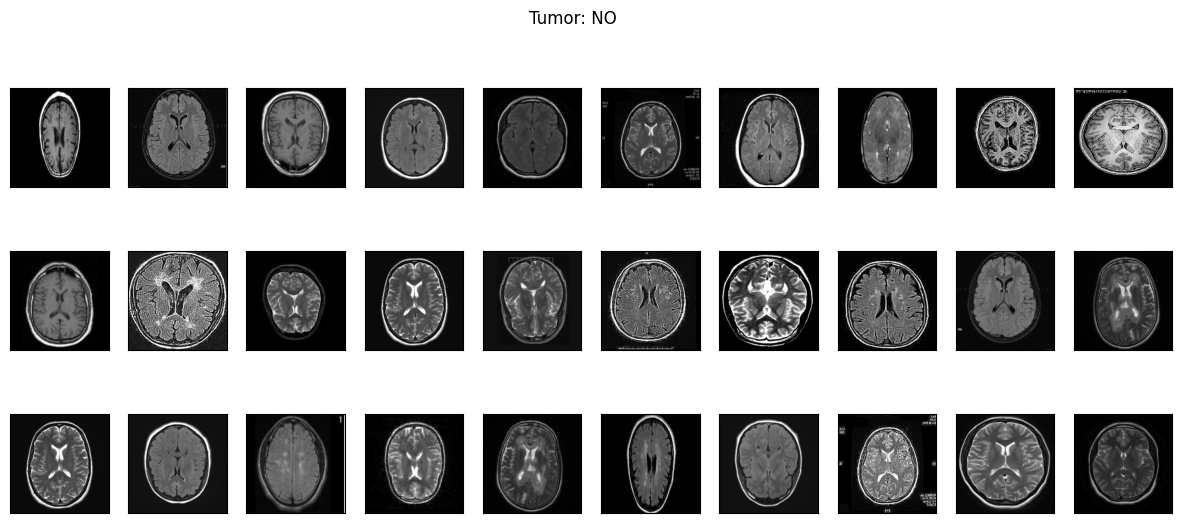

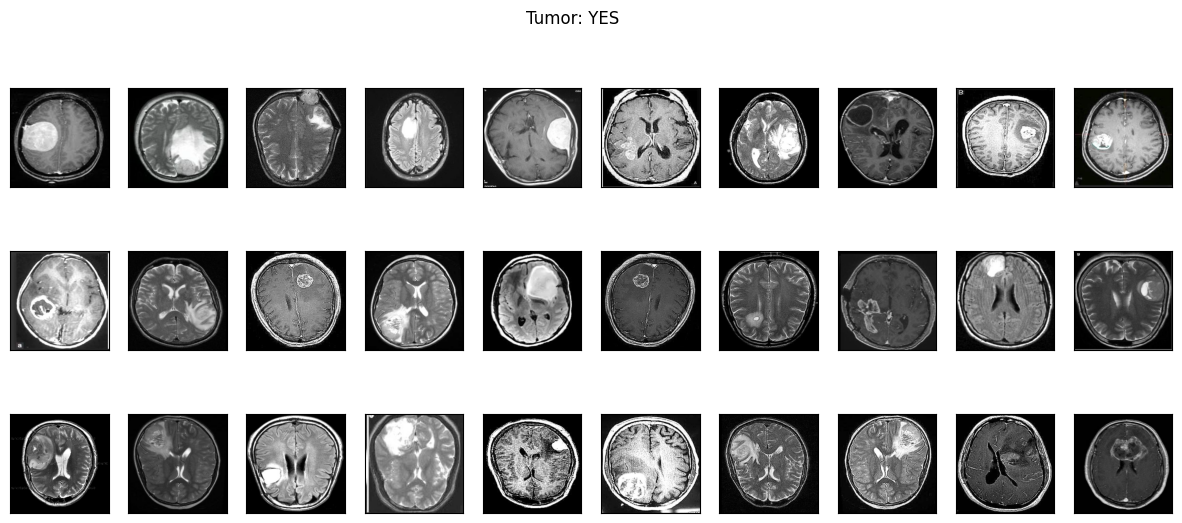

In [ ]:
plot_samples(X_train, y_train, labels, 30)

<h2> Cropping the images </h2>

<p> The images we have are of different sizes. But our model accepts images of size (224*224*3) as input. To achienve this ew have to resize the images. Blindly resizing the images can lead to extreme distortions in the images. Hence, We will first crop thie images and then resize them. This will minimize the issue of distortions. </p>

<p> This cropping is done by finding contours in the images using the OpenCV Library </p>

In [ ]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

        # Define the desired width and height for resizing
        a_consistent_width = 224  # Replace with your desired width
        a_consistent_height = 224 # Replace with your desired height

        # Resize the image to a consistent size
        new_img = cv2.resize(new_img, (a_consistent_width, a_consistent_height))

        set_new.append(new_img)

    return np.array(set_new)

In [ ]:
import imutils
img = cv2.imread('./VAL/NO/no856.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

<h2> Let's visualize how the cropping works </h2>

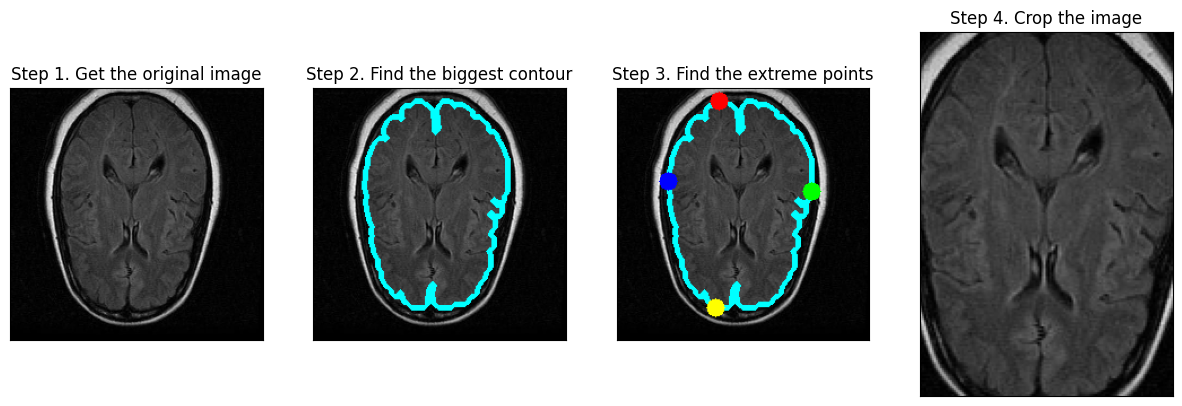

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [ ]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

<h2> Let's visualize the images after being cropped </h2>

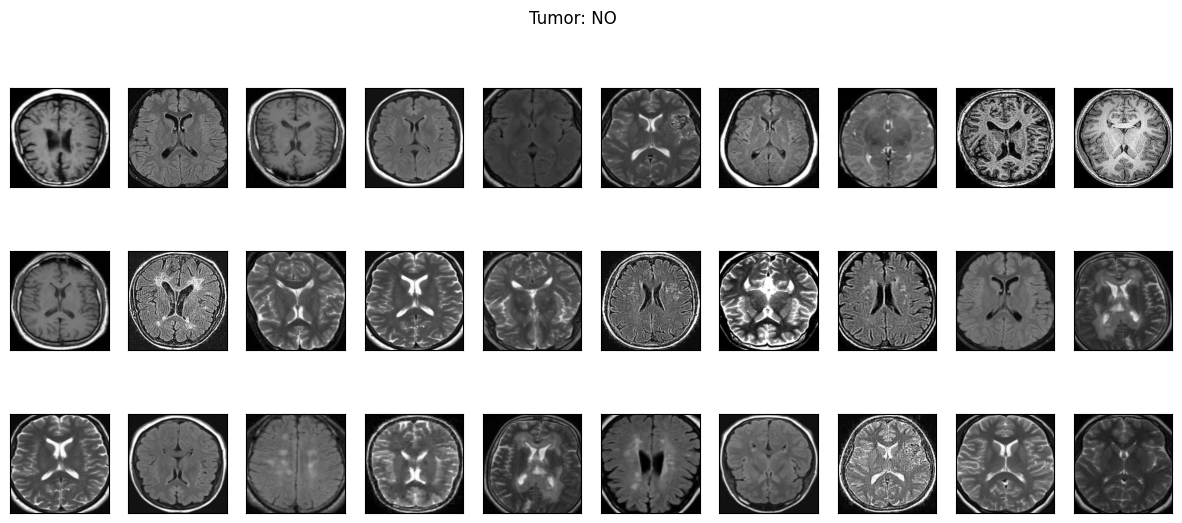

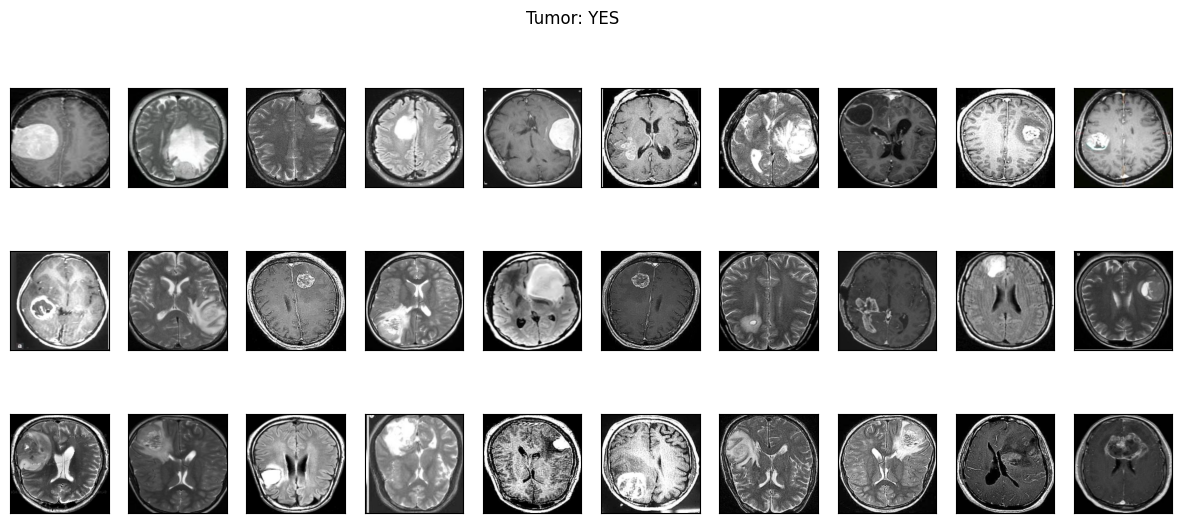

In [ ]:
plot_samples(X_train_crop, y_train, labels, 30)

In [ ]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [ ]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

<h2> Resizing the images </h2>

<p> Now that we have cropped the images, we can resize them without suffering from heavy distortions or resizing artefacts </p>

In [ ]:
def preprocess_imgs(set_name, img_size):
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)


In [ ]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

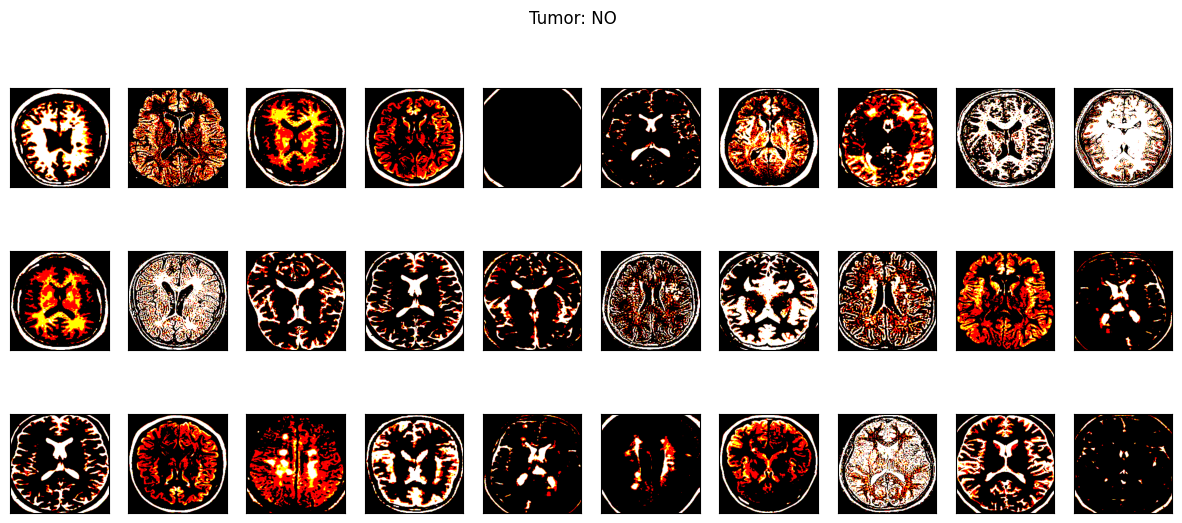

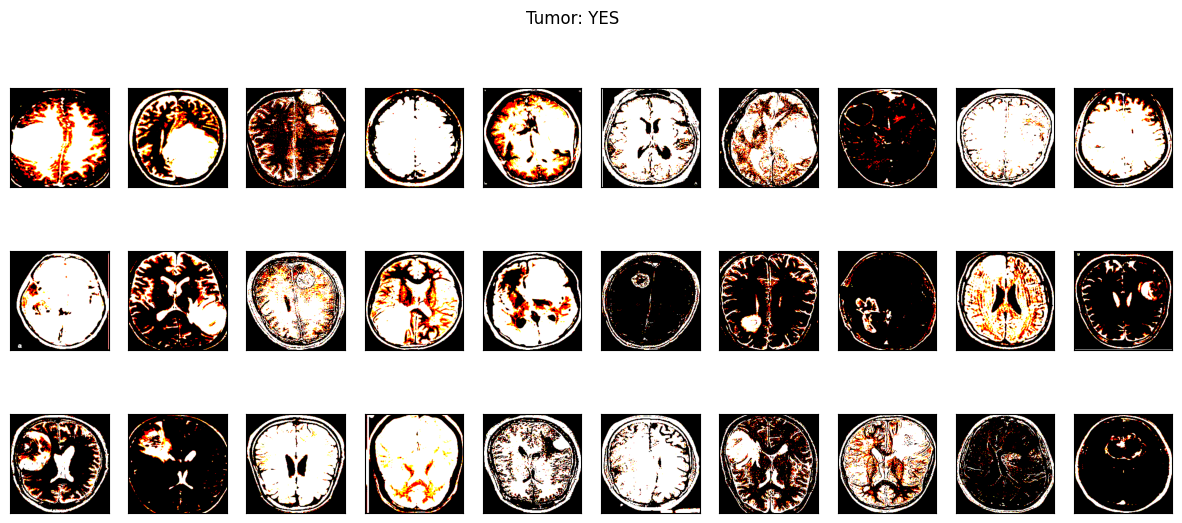

In [ ]:
plot_samples(X_train_prep, y_train, labels, 30)

<h2> Image Augmentation </h2>
<p> We will perform data augmentation to increase the number of training samples we have </p>

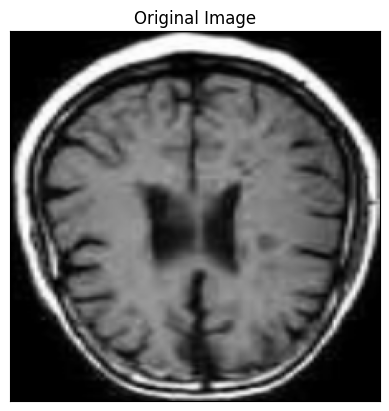

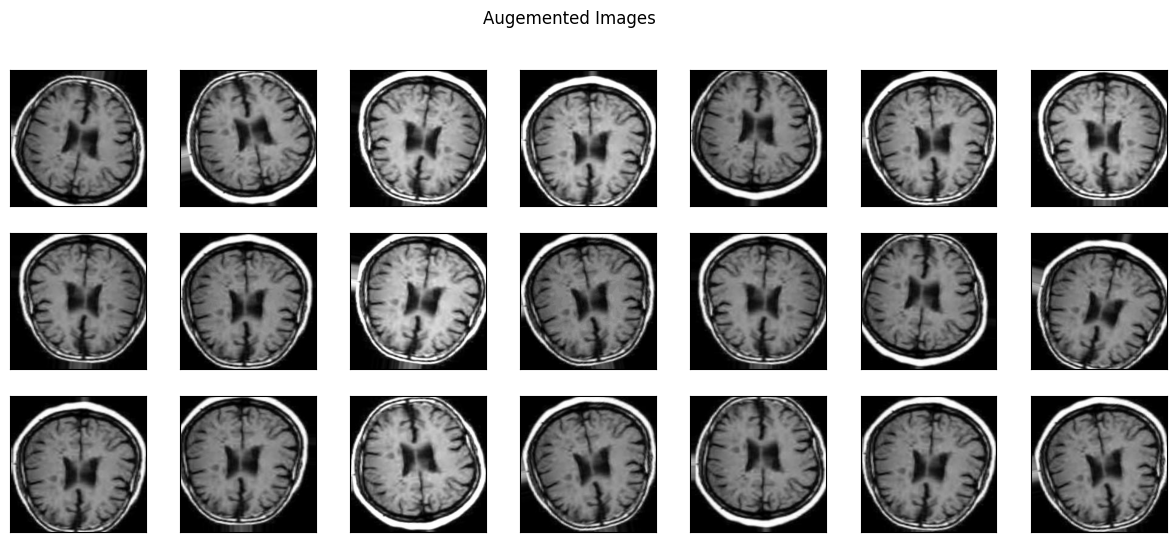

In [ ]:
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

import os

# Check if 'preview' directory exists, and if not, create it
if not os.path.exists('preview'):
    os.mkdir('preview')

# ... rest of your code ...
x = X_train_crop[0]
x = x.reshape((1,) + x.shape)

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break

plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()


In [ ]:
!rm -rf preview/

In [ ]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'
RANDOM_SEED = 42
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 1800 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


<h2> Creating the model </h2>

<p> Here we will be using a pretrained ResNet50 model with ImageNet weights from keras. We will use transfer learning for this task. We will be using binary cross entropy as the loss function and accuracy and AUC as our monitoring metrics. </p>

In [ ]:
base_Neural_Net= ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

for layer in base_Neural_Net.layers:
    layer.trainable = False


model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy' , 'AUC']
)

model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 batch_normalization (Batch  (None, 100352)            401408    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                         

In [ ]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Flatten, BatchNormalization, Dense, Activation, Dropout

# Load the VGG16 model without the top layer
base_Neural_Net2 = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Create a new Sequential model and add the base model
model2 = Sequential()
model2.add(base_Neural_Net)
model2.add(Flatten())
model2.add(BatchNormalization())
model2.add(Dense(256, kernel_initializer='he_uniform'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

# Freeze the layers of the base model
for layer in base_Neural_Net2.layers:
    layer.trainable = False

# Compile the model
model2.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'AUC']
)

# Print the model summary
model2.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 batch_normalization_2 (Bat  (None, 100352)            401408    
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               25690368  
                                                                 
 batch_normalization_3 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                       

In [ ]:
from keras.applications import InceptionV3
from keras.models import Sequential
from keras.layers import Flatten, BatchNormalization, Dense, Activation, Dropout

# Load the InceptionV3 model without the top layer
base_Neural_Net3 = InceptionV3(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Create a new Sequential model and add the base model
model3 = Sequential()
model3.add(base_Neural_Net)
model3.add(Flatten())
model3.add(BatchNormalization())
model3.add(Dense(256, kernel_initializer='he_uniform'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.5))
model3.add(Dense(1, activation='sigmoid'))

# Freeze the layers of the base model
for layer in base_Neural_Net3.layers:
    layer.trainable = False

# Compile the model
model3.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'AUC']
)

# Print the model summary
model3.summary()


87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 batch_normalization_98 (Ba  (None, 100352)            401408    
 tchNormalization)                                               
                                                                 
 dense_4 (Dense)             (None, 256)               25690368  
                                                                 
 batch_normalization_99 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                       

<h2> TRAINING !!! </h2>

In [ ]:
EPOCHS = 10
es = EarlyStopping(
    monitor='val_acc',
    mode='max',
    patience=6
)
history = model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

<ipython-input-31-d4bea7732804>:7: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.5517 - accuracy: 0.7969 - auc: 0.8696

10/10 [==============================] - 21s 887ms/step - loss: 0.5517 - accuracy: 0.7969 - auc: 0.8696 - val_loss: 8.4089 - val_accuracy: 0.6325 - val_auc: 0.6921
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.4041 - accuracy: 0.8446 - auc: 0.9074

10/10 [==============================] - 8s 751ms/step - loss: 0.4041 - accuracy: 0.8446 - auc: 0.9074 - val_loss: 2.1017 - val_accuracy: 0.8050 - val_auc: 0.8798
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.2331 - accuracy: 0.9250 - auc: 0.9689

10/10 [==============================] - 8s 791ms/step - loss: 0.2331 - accuracy: 0.9250 - auc: 0.9689 - val_loss: 1.0237 - val_accuracy: 0.8650 - val_auc: 0.9171
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.2650 - accuracy: 0.8750 - auc: 0.9611

10/10 [==============================] - 6s 621ms/step - loss: 0.2650 - accuracy: 0.8750 - auc: 0.9611 - val_loss: 0.5328 - val_accuracy: 0.8925 - val_auc: 0.9584
Epoch 5/10
10/10 [==============================] - ETA: 0s - loss: 0.2328 - accuracy: 0.9062 - auc: 0.9660

10/10 [==============================] - 7s 711ms/step - loss: 0.2328 - accuracy: 0.9062 - auc: 0.9660 - val_loss: 0.3405 - val_accuracy: 0.9200 - val_auc: 0.9644
Epoch 6/10
10/10 [==============================] - ETA: 0s - loss: 0.1650 - accuracy: 0.9375 - auc: 0.9846

10/10 [==============================] - 8s 878ms/step - loss: 0.1650 - accuracy: 0.9375 - auc: 0.9846 - val_loss: 0.2726 - val_accuracy: 0.9375 - val_auc: 0.9742
Epoch 7/10
10/10 [==============================] - ETA: 0s - loss: 0.2210 - accuracy: 0.9375 - auc: 0.9696

10/10 [==============================] - 6s 608ms/step - loss: 0.2210 - accuracy: 0.9375 - auc: 0.9696 - val_loss: 0.2231 - val_accuracy: 0.9425 - val_auc: 0.9809
Epoch 8/10
10/10 [==============================] - ETA: 0s - loss: 0.1895 - accuracy: 0.9062 - auc: 0.9793

10/10 [==============================] - 7s 718ms/step - loss: 0.1895 - accuracy: 0.9062 - auc: 0.9793 - val_loss: 0.2115 - val_accuracy: 0.9400 - val_auc: 0.9819
Epoch 9/10
10/10 [==============================] - ETA: 0s - loss: 0.1838 - accuracy: 0.9375 - auc: 0.9794

10/10 [==============================] - 8s 872ms/step - loss: 0.1838 - accuracy: 0.9375 - auc: 0.9794 - val_loss: 0.1901 - val_accuracy: 0.9425 - val_auc: 0.9802
Epoch 10/10
10/10 [==============================] - ETA: 0s - loss: 0.2145 - accuracy: 0.9281 - auc: 0.9691

10/10 [==============================] - 8s 783ms/step - loss: 0.2145 - accuracy: 0.9281 - auc: 0.9691 - val_loss: 0.1701 - val_accuracy: 0.9525 - val_auc: 0.9815


In [ ]:
EPOCHS = 10
es = EarlyStopping(
    monitor='val_acc',
    mode='max',
    patience=6
)
history = model2.fit_generator(
    train_generator,
    steps_per_epoch=10,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

<ipython-input-32-fc41d36e1bed>:7: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.6291 - accuracy: 0.7838 - auc: 0.8430

10/10 [==============================] - 14s 990ms/step - loss: 0.6291 - accuracy: 0.7838 - auc: 0.8430 - val_loss: 1.3907 - val_accuracy: 0.8900 - val_auc: 0.9102
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.3564 - accuracy: 0.8716 - auc: 0.9346

10/10 [==============================] - 7s 681ms/step - loss: 0.3564 - accuracy: 0.8716 - auc: 0.9346 - val_loss: 0.8959 - val_accuracy: 0.8875 - val_auc: 0.9219
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.3228 - accuracy: 0.8687 - auc: 0.9389

10/10 [==============================] - 7s 724ms/step - loss: 0.3228 - accuracy: 0.8687 - auc: 0.9389 - val_loss: 0.5335 - val_accuracy: 0.9100 - val_auc: 0.9557
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.3813 - accuracy: 0.8625 - auc: 0.9229

10/10 [==============================] - 7s 727ms/step - loss: 0.3813 - accuracy: 0.8625 - auc: 0.9229 - val_loss: 0.3715 - val_accuracy: 0.9075 - val_auc: 0.9628
Epoch 5/10
10/10 [==============================] - ETA: 0s - loss: 0.2578 - accuracy: 0.9156 - auc: 0.9644

10/10 [==============================] - 8s 865ms/step - loss: 0.2578 - accuracy: 0.9156 - auc: 0.9644 - val_loss: 0.2601 - val_accuracy: 0.9325 - val_auc: 0.9706
Epoch 6/10
10/10 [==============================] - ETA: 0s - loss: 0.2256 - accuracy: 0.9122 - auc: 0.9689

10/10 [==============================] - 7s 690ms/step - loss: 0.2256 - accuracy: 0.9122 - auc: 0.9689 - val_loss: 0.1558 - val_accuracy: 0.9500 - val_auc: 0.9869
Epoch 7/10
10/10 [==============================] - ETA: 0s - loss: 0.1802 - accuracy: 0.9281 - auc: 0.9802

10/10 [==============================] - 8s 877ms/step - loss: 0.1802 - accuracy: 0.9281 - auc: 0.9802 - val_loss: 0.1945 - val_accuracy: 0.9400 - val_auc: 0.9798
Epoch 8/10
10/10 [==============================] - ETA: 0s - loss: 0.1855 - accuracy: 0.9375 - auc: 0.9799

10/10 [==============================] - 8s 785ms/step - loss: 0.1855 - accuracy: 0.9375 - auc: 0.9799 - val_loss: 0.1205 - val_accuracy: 0.9450 - val_auc: 0.9905
Epoch 9/10
10/10 [==============================] - ETA: 0s - loss: 0.1626 - accuracy: 0.9438 - auc: 0.9825

10/10 [==============================] - 6s 607ms/step - loss: 0.1626 - accuracy: 0.9438 - auc: 0.9825 - val_loss: 0.1363 - val_accuracy: 0.9475 - val_auc: 0.9901
Epoch 10/10
10/10 [==============================] - ETA: 0s - loss: 0.2014 - accuracy: 0.9122 - auc: 0.9739

10/10 [==============================] - 7s 713ms/step - loss: 0.2014 - accuracy: 0.9122 - auc: 0.9739 - val_loss: 0.1438 - val_accuracy: 0.9425 - val_auc: 0.9888


In [ ]:
EPOCHS = 10
es = EarlyStopping(
    monitor='val_acc',
    mode='max',
    patience=6
)
history = model3.fit_generator(
    train_generator,
    steps_per_epoch=10,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

<ipython-input-33-881962e9984a>:7: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.6984 - accuracy: 0.7500 - auc: 0.8428

10/10 [==============================] - 14s 874ms/step - loss: 0.6984 - accuracy: 0.7500 - auc: 0.8428 - val_loss: 13.3772 - val_accuracy: 0.5725 - val_auc: 0.5875
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.4924 - accuracy: 0.8281 - auc: 0.8988

10/10 [==============================] - 7s 771ms/step - loss: 0.4924 - accuracy: 0.8281 - auc: 0.8988 - val_loss: 3.9838 - val_accuracy: 0.7150 - val_auc: 0.7915
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.3983 - accuracy: 0.8469 - auc: 0.9207

10/10 [==============================] - 7s 727ms/step - loss: 0.3983 - accuracy: 0.8469 - auc: 0.9207 - val_loss: 1.8143 - val_accuracy: 0.7525 - val_auc: 0.8760
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.2587 - accuracy: 0.9187 - auc: 0.9590

10/10 [==============================] - 6s 613ms/step - loss: 0.2587 - accuracy: 0.9187 - auc: 0.9590 - val_loss: 0.7290 - val_accuracy: 0.8700 - val_auc: 0.9397
Epoch 5/10
10/10 [==============================] - ETA: 0s - loss: 0.3030 - accuracy: 0.9031 - auc: 0.9489

10/10 [==============================] - 7s 767ms/step - loss: 0.3030 - accuracy: 0.9031 - auc: 0.9489 - val_loss: 0.4541 - val_accuracy: 0.9025 - val_auc: 0.9565
Epoch 6/10
10/10 [==============================] - ETA: 0s - loss: 0.2328 - accuracy: 0.8938 - auc: 0.9669

10/10 [==============================] - 7s 731ms/step - loss: 0.2328 - accuracy: 0.8938 - auc: 0.9669 - val_loss: 0.3762 - val_accuracy: 0.9150 - val_auc: 0.9721
Epoch 7/10
10/10 [==============================] - ETA: 0s - loss: 0.1817 - accuracy: 0.9324 - auc: 0.9813

10/10 [==============================] - 7s 686ms/step - loss: 0.1817 - accuracy: 0.9324 - auc: 0.9813 - val_loss: 0.3328 - val_accuracy: 0.9300 - val_auc: 0.9758
Epoch 8/10
10/10 [==============================] - ETA: 0s - loss: 0.1723 - accuracy: 0.9406 - auc: 0.9831

10/10 [==============================] - 8s 787ms/step - loss: 0.1723 - accuracy: 0.9406 - auc: 0.9831 - val_loss: 0.2398 - val_accuracy: 0.9275 - val_auc: 0.9856
Epoch 9/10
10/10 [==============================] - ETA: 0s - loss: 0.2211 - accuracy: 0.9122 - auc: 0.9720

10/10 [==============================] - 6s 626ms/step - loss: 0.2211 - accuracy: 0.9122 - auc: 0.9720 - val_loss: 0.2887 - val_accuracy: 0.9250 - val_auc: 0.9773
Epoch 10/10
10/10 [==============================] - ETA: 0s - loss: 0.1825 - accuracy: 0.9281 - auc: 0.9807

10/10 [==============================] - 8s 800ms/step - loss: 0.1825 - accuracy: 0.9281 - auc: 0.9807 - val_loss: 0.2316 - val_accuracy: 0.9375 - val_auc: 0.9793


<h2>Let's have a look at the performance of our model </h2>

<h3> Validating with the training set </h3>

57/57 [==============================] - 6s 92ms/step
Train Accuracy = 0.97


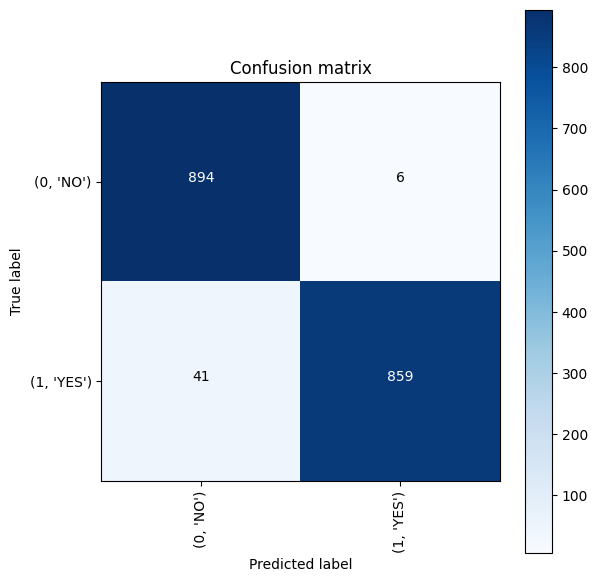

In [ ]:
predictions = model.predict(X_train_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_train, predictions)
print('Train Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_train, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

57/57 [==============================] - 5s 91ms/step
Train Accuracy = 0.97


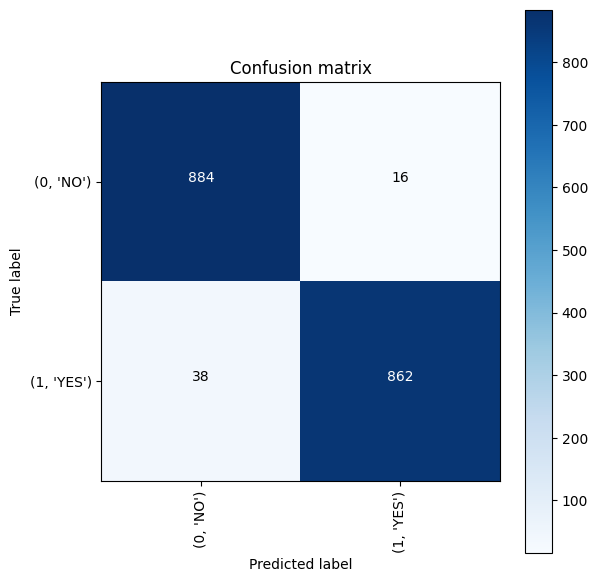

In [ ]:
predictions2 = model2.predict(X_train_prep)
predictions2 = [1 if x>0.5 else 0 for x in predictions2]

accuracy2 = accuracy_score(y_train, predictions2)
print('Train Accuracy = %.2f' % accuracy2)

confusion_mtx2 = confusion_matrix(y_train, predictions2)
cm2 = plot_confusion_matrix(confusion_mtx2, classes = list(labels.items()), normalize=False)

57/57 [==============================] - 5s 92ms/step
Train Accuracy = 0.96


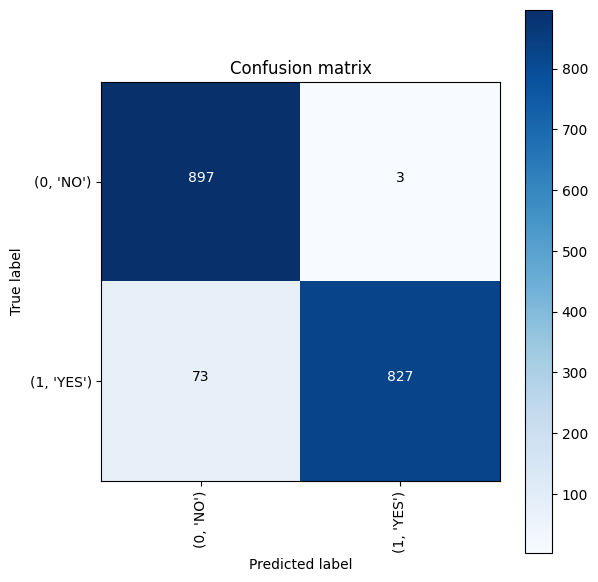

In [ ]:
predictions3 = model3.predict(X_train_prep)
predictions3 = [1 if x>0.5 else 0 for x in predictions3]

accuracy3 = accuracy_score(y_train, predictions3)
print('Train Accuracy = %.2f' % accuracy3)

confusion_mtx3 = confusion_matrix(y_train, predictions3)
cm3 = plot_confusion_matrix(confusion_mtx3, classes = list(labels.items()), normalize=False)

<h3> Validating with the Validation set</h3>

19/19 [==============================] - 2s 92ms/step
Val Accuracy = 0.95


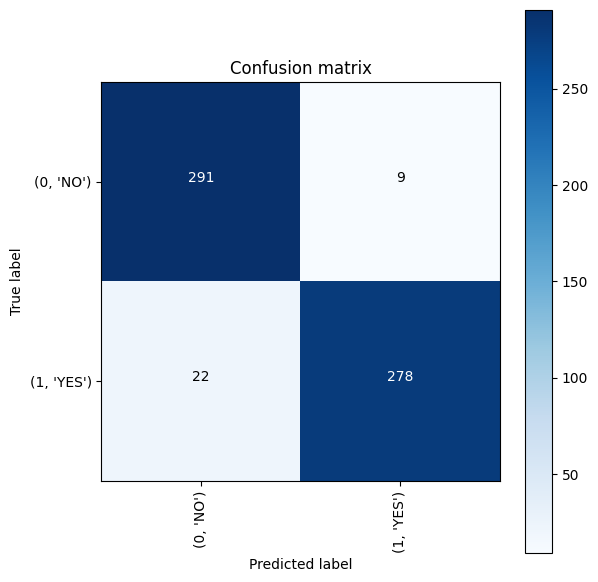

In [ ]:
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

19/19 [==============================] - 2s 98ms/step
Val Accuracy = 0.94


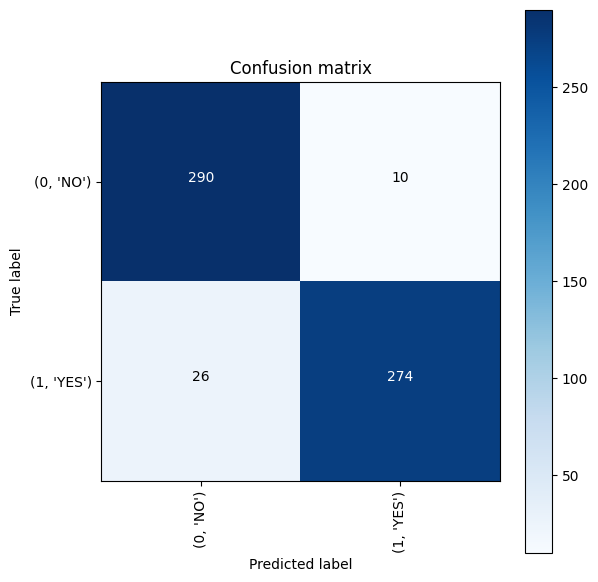

In [ ]:
predictions2 = model2.predict(X_val_prep)
predictions2 = [1 if x>0.5 else 0 for x in predictions2]

accuracy2 = accuracy_score(y_val, predictions2)
print('Val Accuracy = %.2f' % accuracy2)

confusion_mtx2 = confusion_matrix(y_val, predictions2)
cm2 = plot_confusion_matrix(confusion_mtx2, classes = list(labels.items()), normalize=False)

19/19 [==============================] - 2s 92ms/step
Val Accuracy = 0.95


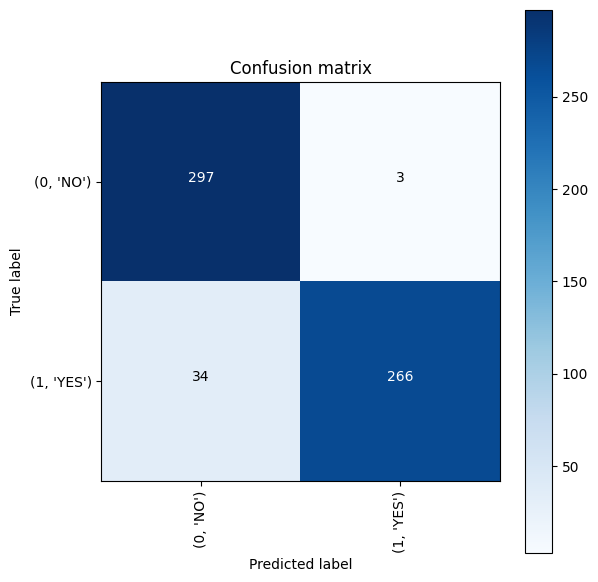

In [ ]:
predictions3 = model3.predict(X_val_prep)
predictions3 = [1 if x>0.5 else 0 for x in predictions3]

accuracy3 = accuracy_score(y_val, predictions3)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx3 = confusion_matrix(y_val, predictions3)
cm3 = plot_confusion_matrix(confusion_mtx3, classes = list(labels.items()), normalize=False)

* <h3> Validating with the Test set</h3>

19/19 [==============================] - 2s 92ms/step
Test Accuracy = 0.96


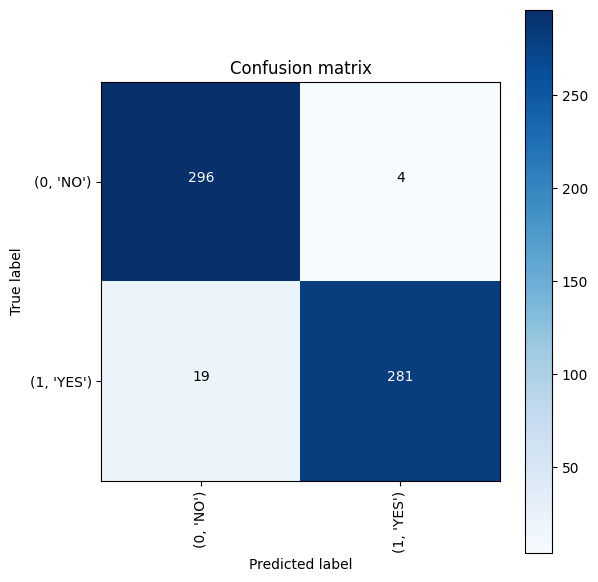

In [ ]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
prob_pred = model.predict(X_test_prep)

19/19 [==============================] - 2s 96ms/step


19/19 [==============================] - 2s 91ms/step
Val Accuracy = 0.94


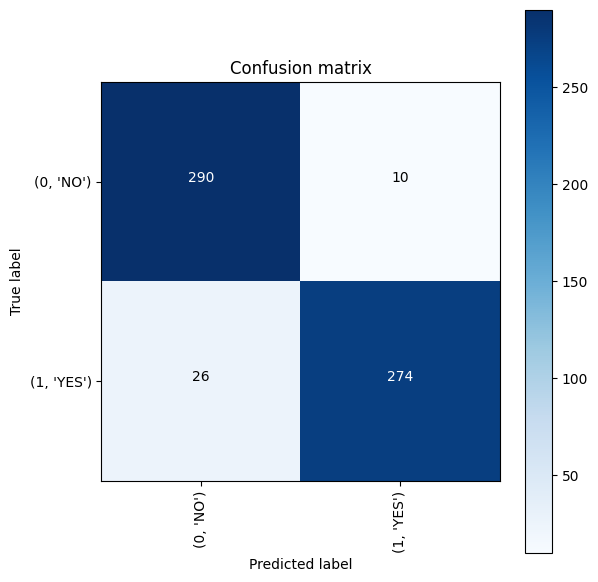

In [ ]:
predictions2 = model2.predict(X_val_prep)
predictions2 = [1 if x>0.5 else 0 for x in predictions2]

accuracy2 = accuracy_score(y_val, predictions2)
print('Val Accuracy = %.2f' % accuracy2)

confusion_mtx2 = confusion_matrix(y_val, predictions2)
cm2 = plot_confusion_matrix(confusion_mtx2, classes = list(labels.items()), normalize=False)

In [ ]:
prob_pred2 = model2.predict(X_test_prep)

19/19 [==============================] - 2s 93ms/step


19/19 [==============================] - 2s 97ms/step
Val Accuracy = 0.94


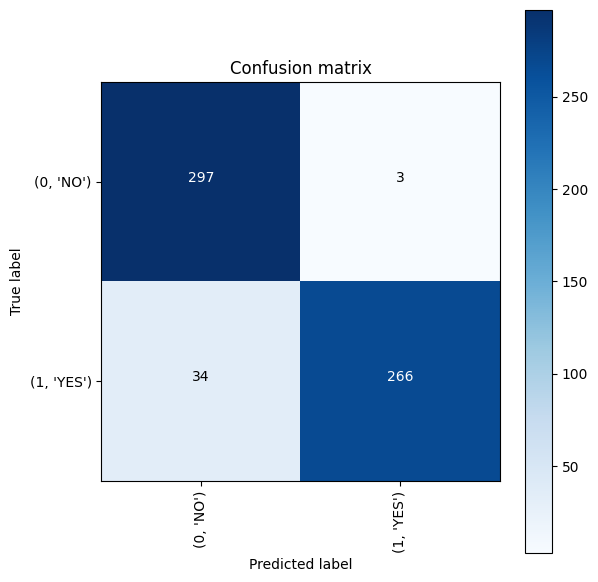

In [ ]:
predictions3 = model3.predict(X_val_prep)
predictions3 = [1 if x>0.5 else 0 for x in predictions3]

accuracy3 = accuracy_score(y_val, predictions3)
print('Val Accuracy = %.2f' % accuracy3)

confusion_mtx3 = confusion_matrix(y_val, predictions3)
cm3 = plot_confusion_matrix(confusion_mtx3, classes = list(labels.items()), normalize=False)

In [ ]:
prob_pred3 = model3.predict(X_test_prep)

19/19 [==============================] - 2s 92ms/step


<h2> Let's see the other performance metrics on the test set </h2>

In [ ]:
from sklearn import metrics
print('Accuracy score is :', np.round(metrics.accuracy_score(y_test, predictions),4))
print('Precision score is :', np.round(metrics.precision_score(y_test, predictions, average='weighted'),4))
print('Recall score is :', np.round(metrics.recall_score(y_test, predictions, average='weighted'),4))
print('F1 Score is :', np.round(metrics.f1_score(y_test, predictions, average='weighted'),4))
print('ROC AUC Score is :', np.round(metrics.roc_auc_score(y_test, prob_pred,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, predictions),4))

print('\t\tClassification Report:\n', metrics.classification_report(y_test, predictions))

Accuracy score is : 0.94
Precision score is : 0.9413
Recall score is : 0.94
F1 Score is : 0.94
ROC AUC Score is : 0.9927
Cohen Kappa Score: 0.88
		Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.94       300
           1       0.96      0.91      0.94       300

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



In [ ]:
from sklearn import metrics
print('Accuracy score is :', np.round(metrics.accuracy_score(y_test, predictions2),4))
print('Precision score is :', np.round(metrics.precision_score(y_test, predictions2, average='weighted'),4))
print('Recall score is :', np.round(metrics.recall_score(y_test, predictions2, average='weighted'),4))
print('F1 Score is :', np.round(metrics.f1_score(y_test, predictions2, average='weighted'),4))
print('ROC AUC Score is :', np.round(metrics.roc_auc_score(y_test, prob_pred,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, predictions2),4))

print('\t\tClassification Report:\n', metrics.classification_report(y_test, predictions2))

Accuracy score is : 0.94
Precision score is : 0.9413
Recall score is : 0.94
F1 Score is : 0.94
ROC AUC Score is : 0.9927
Cohen Kappa Score: 0.88
		Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.94       300
           1       0.96      0.91      0.94       300

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



In [ ]:
from sklearn import metrics
print('Accuracy score is :', np.round(metrics.accuracy_score(y_test, predictions3),4))
print('Precision score is :', np.round(metrics.precision_score(y_test, predictions3, average='weighted'),4))
print('Recall score is :', np.round(metrics.recall_score(y_test, predictions3, average='weighted'),4))
print('F1 Score is :', np.round(metrics.f1_score(y_test, predictions3, average='weighted'),4))
print('ROC AUC Score is :', np.round(metrics.roc_auc_score(y_test, prob_pred,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, predictions3),4))

print('\t\tClassification Report:\n', metrics.classification_report(y_test, predictions3))

Accuracy score is : 0.9383
Precision score is : 0.9431
Recall score is : 0.9383
F1 Score is : 0.9382
ROC AUC Score is : 0.9927
Cohen Kappa Score: 0.8767
		Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94       300
           1       0.99      0.89      0.93       300

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



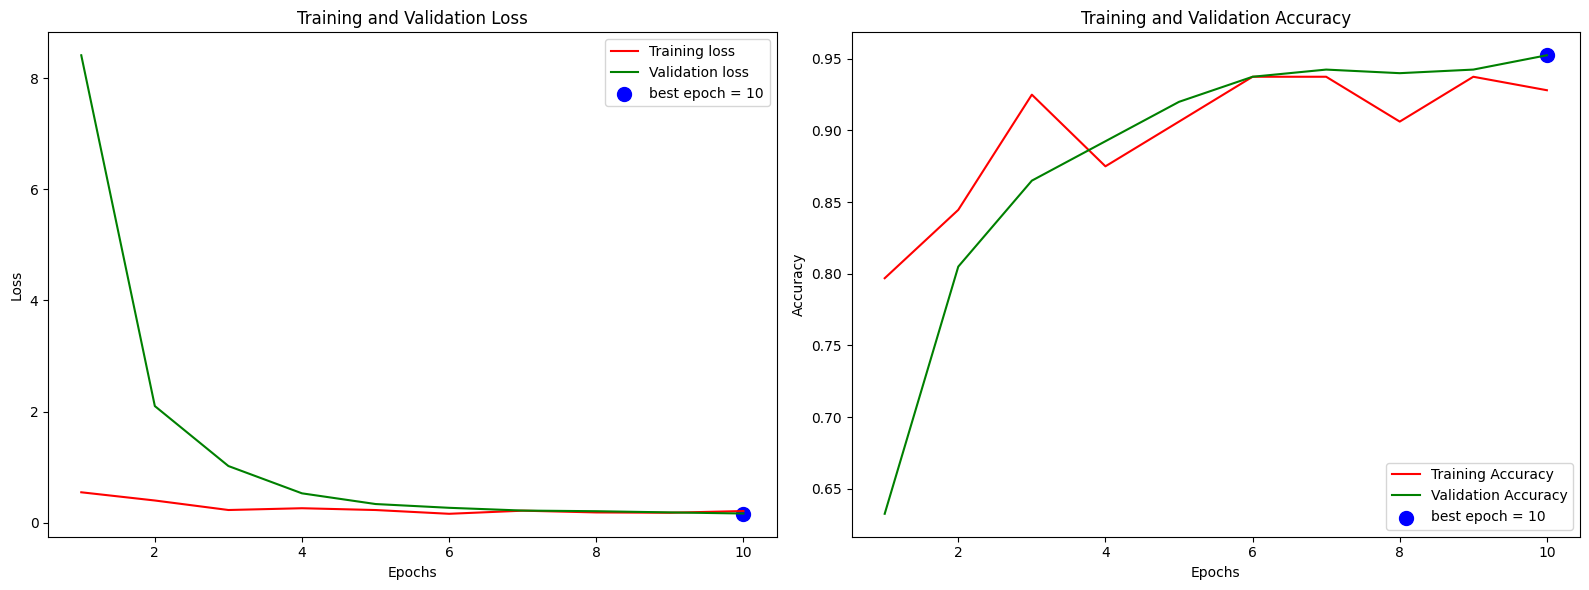

In [1]:
import matplotlib.pyplot as plt

# Data extracted from your logs
history = {
    'loss': [0.5517, 0.4041, 0.2331, 0.2650, 0.2328, 0.1650, 0.2210, 0.1895, 0.1838, 0.2145],
    'val_loss': [8.4089, 2.1017, 1.0237, 0.5328, 0.3405, 0.2726, 0.2231, 0.2115, 0.1901, 0.1701],
    'accuracy': [0.7969, 0.8446, 0.9250, 0.8750, 0.9062, 0.9375, 0.9375, 0.9062, 0.9375, 0.9281],
    'val_accuracy': [0.6325, 0.8050, 0.8650, 0.8925, 0.9200, 0.9375, 0.9425, 0.9400, 0.9425, 0.9525]
}

epochs = range(1, len(history['loss']) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['loss'], 'r-', label='Training loss')
plt.plot(epochs, history['val_loss'], 'g-', label='Validation loss')
plt.scatter(history['val_loss'].index(min(history['val_loss'])) + 1, min(history['val_loss']), c='blue', s=100, label='best epoch = {}'.format(history['val_loss'].index(min(history['val_loss'])) + 1))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history['accuracy'], 'r-', label='Training Accuracy')
plt.plot(epochs, history['val_accuracy'], 'g-', label='Validation Accuracy')
plt.scatter(history['val_accuracy'].index(max(history['val_accuracy'])) + 1, max(history['val_accuracy']), c='blue', s=100, label='best epoch = {}'.format(history['val_accuracy'].index(max(history['val_accuracy'])) + 1))
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


<h2> Conclusion </h2>
<p> A seen from the metrics, the model performs pretty well. We are able to correctly classify all the images in the test set with very few false positives and false negatives in the validation set. This performance can be firther enhanced by hyper parameter tuning. </p>

In [ ]:
# clean up the space
!rm -rf TRAIN TEST VAL TRAIN_CROP TEST_CROP VAL_CROP